In [16]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report ,confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, log_loss
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

**DATA**

Between June 2011 and September 2024

In [17]:

# Load your oil price data
df = pd.read_excel('../data/processed/data.xlsx', parse_dates=True, index_col='Ay')

# Labeling: Define volatility change
df['target'] = df['dev'].apply(lambda x: 1 if x > 0 else -1)


# Drop missing values caused by rolling operations and shift
df = df.dropna()
X = df.drop(columns=['dev', 'target', 'monthly_finbert_score_sum', 'monthly_headline_count', 'avg 30d volatility'])  # Features
y = df['target'] 

**"dev" from data is deviation from the sample mean of volatility that is 32, volatility values that are higher from this mean is labeled as high and vice versa**

In [18]:
df.head()

,monthly_finbert_score_mean,monthly_finbert_score_sum,monthly_headline_count,"""war_i""","""iran_i""","""arab_i""","""strike_i""","""oil_i""","""climate_w""","""war_w""",...,"""T3_STCHANGE_WORLD""","""T3_STCHANGE_US""","""T3_STCHANGE_OOECD""","""T3_STCHANGE_NOECD""","""PASC_OECD_T3""","""PASC_US""","""PASC_OOECD_T3""",avg 30d volatility,dev,target
Ay,,,,,,,,,,,,,,,,,,,,,
2011-06-01,0.038733,2.052839,53,41,5,32,21,16,15,21,...,1.43,-0.06,0.37,1.12,2670,1057,1613,35.153636,0.644286,1
2011-07-01,0.039127,3.912672,100,38,5,31,19,14,12,20,...,0.62,-0.23,0.00,0.85,2685,1072,1613,32.644286,-0.800435,-1
2011-08-01,0.042993,4.514316,105,38,4,25,20,16,13,23,...,1.94,0.65,0.04,1.24,2686,1074,1612,31.199565,-1.001818,-1
2011-09-01,0.057855,4.165561,72,40,5,33,20,14,17,27,...,1.82,0.53,0.60,0.69,2652,1058,1594,30.998182,1.943333,1
2011-10-01,0.048162,3.612182,75,41,5,32,19,15,17,25,...,0.40,0.39,0.39,-0.39,2628,1046,1582,33.943333,-2.846818,-1


**Calculate best features using Random Forest Classifier**

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance
rf_importances = rf_model.feature_importances_

# Create a DataFrame to display the feature importance
rf_feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_importances
})

# Sort the features by importance
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='importance', ascending=False)

top_features = rf_feature_importance_df.head(20)

X = X[top_features['feature']]

# Display the feature importances
print(rf_feature_importance_df)
print(X.columns)

                       feature  importance
13                     "WTI_w"    0.084859
12                   "crude_w"    0.084333
20                         DXY    0.055960
14               "oil price_w"    0.044923
31              "COPR_NONOPEC"    0.034442
15                    "OPEC_w"    0.030015
18                         VIX    0.029288
5                      "oil_i"    0.027839
0   monthly_finbert_score_mean    0.027339
45           "PATC_OTHER_ASIA"    0.026561
30              "PAPR_NONOPEC"    0.024720
29                   "OPEC_NC"    0.023744
7                      "war_w"    0.023030
16                    "oil_sa"    0.022499
8                    "saudi_w"    0.020418
41             "PATC_NON_OECD"    0.019013
50         "T3_STCHANGE_NOECD"    0.018820
25                "COPR_WORLD"    0.018206
51              "PASC_OECD_T3"    0.018172
10                    "iran_w"    0.017058
19                         SPY    0.016214
24                "PAPR_WORLD"    0.016053
52         

**Drop features that are highly correlated**

In [20]:
X = X.drop(columns=['"crude_w"', '"PATC_OTHER_ASIA"', '"PAPR_NONOPEC"', '"oil_i"'])

In [21]:
top_16_features = top_features[~top_features['feature'].isin(['"crude_w"', '"PATC_OTHER_ASIA"', '"PAPR_NONOPEC"', '"oil_i"'])]

**Present feature statistics**

In [22]:
# Create an empty DataFrame to store the statistics
stats_df = pd.DataFrame()

# Loop through each feature in the top features list
for feature in top_16_features['feature']:
    # Compute descriptive statistics for the feature
    stats = X[feature].describe()
    
    # Calculate skewness and kurtosis
    skewness = X[feature].skew()
    kurtosis = X[feature].kurt()

    stats = stats.drop(labels='count')
    
    # Add skewness and kurtosis to the stats
    stats['skewness'] = skewness
    stats['kurtosis'] = kurtosis
    
    # Add the stats to the DataFrame with the feature name
    stats_df[feature] = stats

# Transpose the DataFrame for better readability
stats_df = stats_df.T

# Set an appropriate column name for the features
stats_df.index.name = 'Feature'

# Reset index if you want a flat structure
stats_df.reset_index(inplace=True)

# Display the resulting DataFrame
print(stats_df)


                       Feature         mean         std      min          25%  \
0                      "WTI_w"     8.081761    8.910930     2.00     4.000000   
1                          DXY    93.265723    8.822127    73.90    86.430000   
2                "oil price_w"    21.484277   11.065315     7.00    14.500000   
3               "COPR_NONOPEC"    47.337736    1.983479    43.09    46.315000   
4                     "OPEC_w"     2.622642    1.931351     1.00     2.000000   
5                          VIX    18.301258    6.869176     9.51    13.580000   
6   monthly_finbert_score_mean     0.305826    0.078899     0.00     0.282599   
7                    "OPEC_NC"     5.148113    0.165752     4.66     5.010000   
8                      "war_w"    27.823899    5.874785    19.00    23.000000   
9                     "oil_sa"    53.767296   17.682930    21.00    36.500000   
10                   "saudi_w"    16.081761    3.006256    12.00    14.000000   
11             "PATC_NON_OEC

**Plot top features by importance**

C:\Users\abdul\AppData\Local\Temp\ipykernel_4856\1274990395.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_16_features_sorted, palette='viridis')


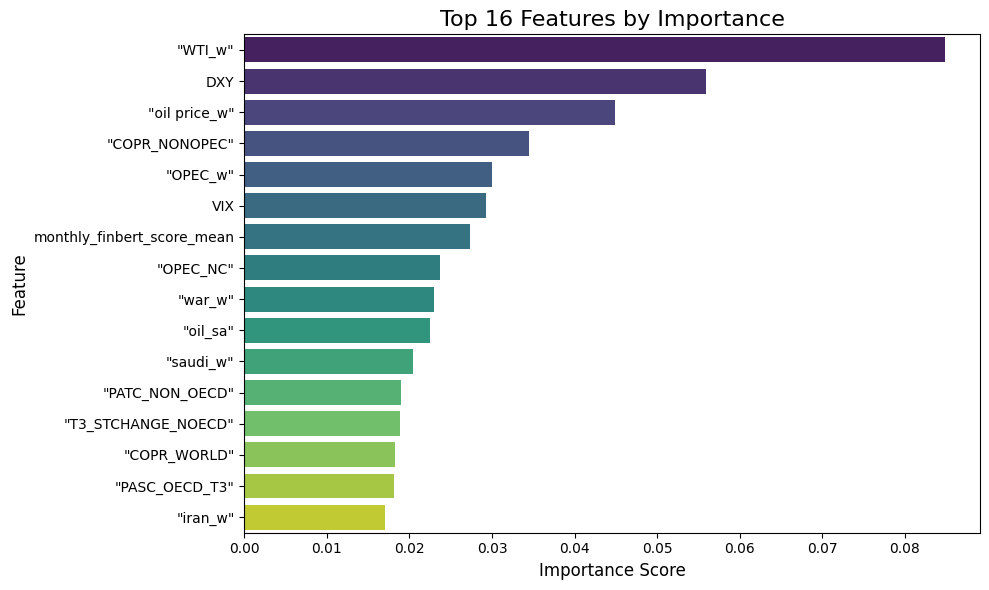

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the top features by their importance scores
top_16_features_sorted = top_16_features.sort_values(by='importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=top_16_features_sorted, palette='viridis')
plt.title('Top 16 Features by Importance', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()


**Correlation matrix of selected features**

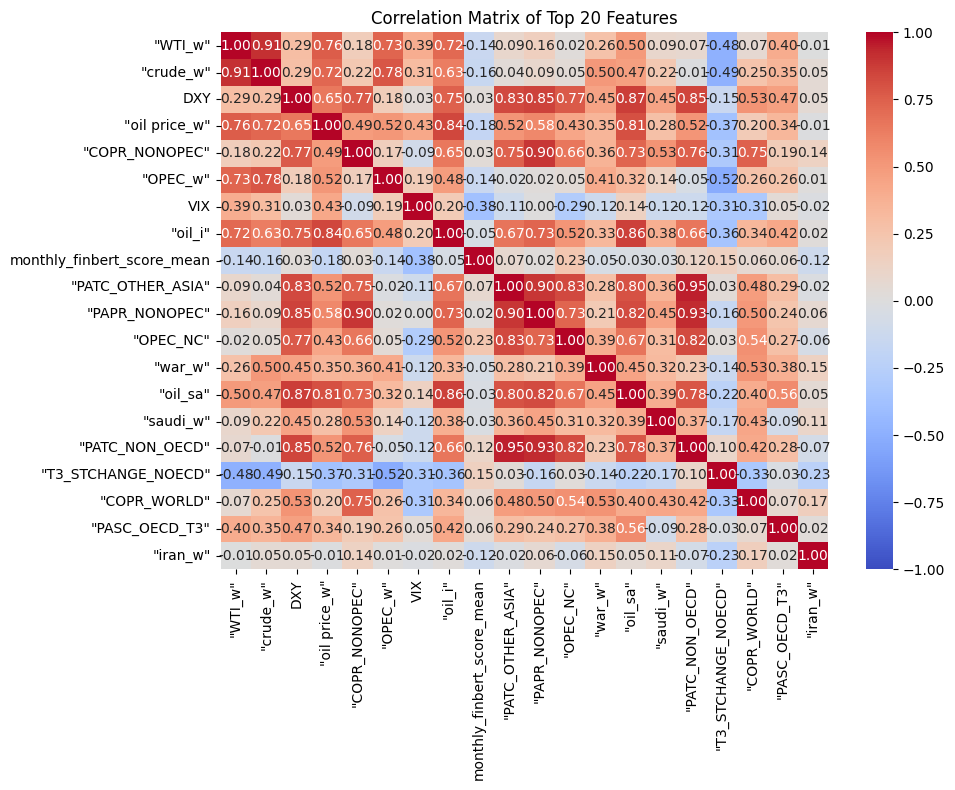

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the names of the top features
top_feature_names = top_features['feature'].values  # Ensure this is an array of valid column names

# Subset the dataset to include only the top features
top_feature_data = df[top_feature_names]  # Ensure df is a DataFrame with these column names


# Calculate the correlation matrix
correlation_matrix = top_feature_data.corr()

# Plot the correlation matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, 
            xticklabels=top_feature_names, yticklabels=top_feature_names, 
            vmin=-1, vmax=1)  # Set range explicitly to -1 to 1
plt.title('Correlation Matrix of Top 20 Features')
plt.tight_layout()
plt.show()


## Below are classification models, we used 5-fold cross validation, 0.5 as probability threshold, cross entropy loss as loss function 

**Fit Random Forest Classifier model and display performance metrics**

Random Forest Classification Report (Cross-Validation):
              precision    recall  f1-score   support

          -1       0.81      0.86      0.84        94
           1       0.78      0.71      0.74        65

    accuracy                           0.80       159
   macro avg       0.79      0.78      0.79       159
weighted avg       0.80      0.80      0.80       159

    -1   1
-1  81  13
 1  19  46


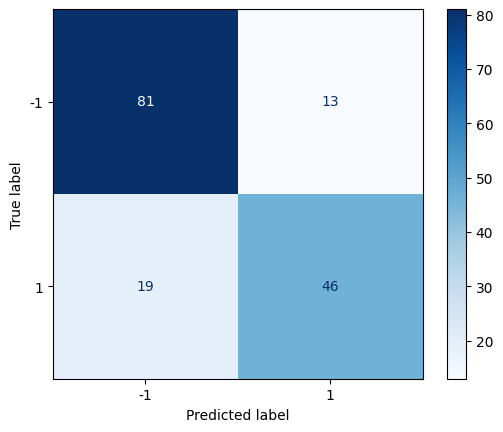

Mean Cross-Entropy Loss (Log Loss): 0.5947


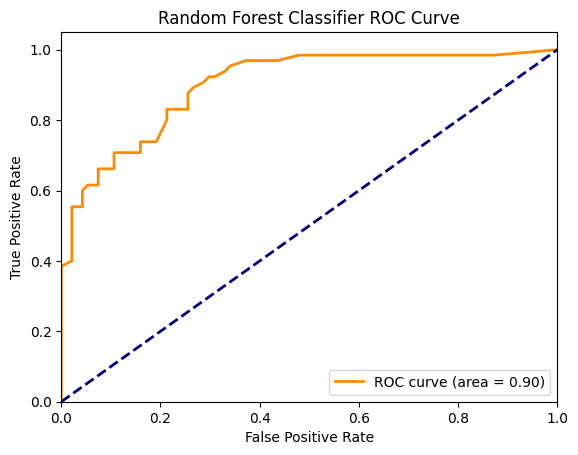

In [25]:
# Define the model
model = RandomForestClassifier(random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize variables to store overall results
all_y_test = []
all_y_pred = []
all_y_prob = []
log_losses = []

# Perform Stratified K-Fold Cross-Validation
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

    # Store results for each fold
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_prob.extend(y_prob)

    fold_log_loss = log_loss(y_test, y_prob)
    log_losses.append(fold_log_loss)

# Evaluate the overall performance

# Classification Report
print("Random Forest Classification Report (Cross-Validation):")
print(classification_report(all_y_test, all_y_pred))

# 1. Confusion Matrix
cm = confusion_matrix(all_y_test, all_y_pred)


# Create a DataFrame with proper labels for better readability
cm_df = pd.DataFrame(cm, index=model.classes_, columns=model.classes_)
print(cm_df)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.show()

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(all_y_test, all_y_prob)
roc_auc = auc(fpr, tpr)

mean_log_loss = np.mean(log_losses)
print(f"Mean Cross-Entropy Loss (Log Loss): {mean_log_loss:.4f}")

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Classifier ROC Curve')
plt.legend(loc="lower right")
plt.show()


**Fit Gradient Boosting Classifier model and display performance metrics**

Gradient Boosting Classification Report (Cross-Validation):
              precision    recall  f1-score   support

          -1       0.83      0.86      0.84        94
           1       0.79      0.74      0.76        65

    accuracy                           0.81       159
   macro avg       0.81      0.80      0.80       159
weighted avg       0.81      0.81      0.81       159

    -1   1
-1  81  13
 1  17  48
Mean Cross-Entropy Loss (Log Loss): 0.6894


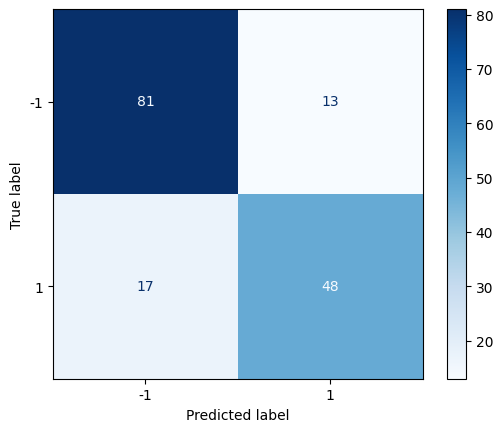

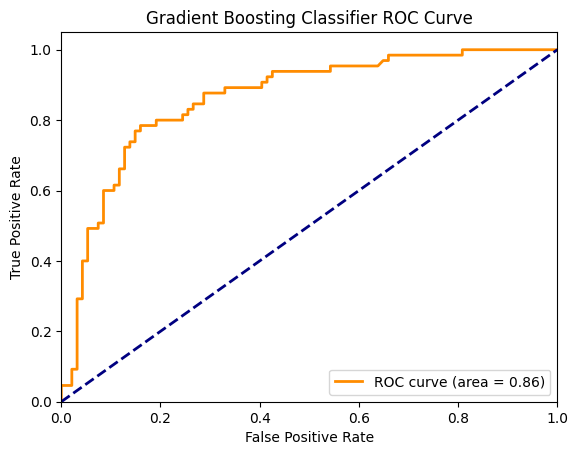

In [26]:
# Define the Gradient Boosting model
gb = GradientBoostingClassifier(random_state=42)

# Initialize the StratifiedKFold for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize variables to store overall results
all_y_test = []
all_y_pred = []
all_y_prob = []

log_losses = []

# Perform Stratified K-Fold Cross-Validation
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    gb.fit(X_train, y_train)

    # Make predictions
    y_pred = gb.predict(X_test)
    y_prob = gb.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

    # Store results for each fold
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_prob.extend(y_prob)

    fold_log_loss = log_loss(y_test, y_prob)
    log_losses.append(fold_log_loss)

# Evaluate the overall performance

# Classification Report
print("Gradient Boosting Classification Report (Cross-Validation):")
print(classification_report(all_y_test, all_y_pred))

# 1. Confusion Matrix
cm = confusion_matrix(all_y_test, all_y_pred)

# Create a DataFrame with proper labels for better readability
cm_df = pd.DataFrame(cm, index=model.classes_, columns=model.classes_)
print(cm_df)

mean_log_loss = np.mean(log_losses)
print(f"Mean Cross-Entropy Loss (Log Loss): {mean_log_loss:.4f}")

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gb.classes_)
disp.plot(cmap="Blues")
plt.show()

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(all_y_test, all_y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boosting Classifier ROC Curve')
plt.legend(loc="lower right")
plt.show()


**Fit logistic Regression Classification model and display performance metrics**

Logistic Regression Classification Report (Cross-Validation):
              precision    recall  f1-score   support

          -1       0.82      0.85      0.84        94
           1       0.77      0.74      0.76        65

    accuracy                           0.81       159
   macro avg       0.80      0.79      0.80       159
weighted avg       0.80      0.81      0.80       159

    -1   1
-1  80  14
 1  17  48
Mean Cross-Entropy Loss (Log Loss): 0.4886


c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

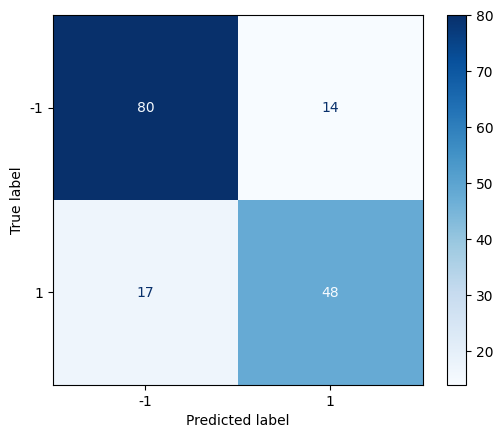

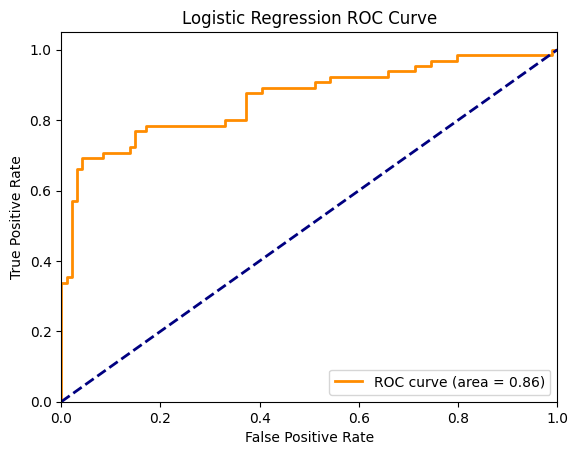

In [27]:
# Define the Logistic Regression model
log_reg = LogisticRegression(random_state=42)

# Initialize the StratifiedKFold for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize variables to store overall results
all_y_test = []
all_y_pred = []
all_y_prob = []
log_losses = []

# Perform Stratified K-Fold Cross-Validation
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    log_reg.fit(X_train, y_train)

    # Make predictions
    y_pred = log_reg.predict(X_test)
    y_prob = log_reg.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

    # Store results for each fold
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_prob.extend(y_prob)

    fold_log_loss = log_loss(y_test, y_prob)
    log_losses.append(fold_log_loss)

# Evaluate the overall performance

# Classification Report
print("Logistic Regression Classification Report (Cross-Validation):")
print(classification_report(all_y_test, all_y_pred))

# 1. Confusion Matrix
cm = confusion_matrix(all_y_test, all_y_pred)

# Create a DataFrame with proper labels for better readability
cm_df = pd.DataFrame(cm, index=model.classes_, columns=model.classes_)
print(cm_df)

mean_log_loss = np.mean(log_losses)
print(f"Mean Cross-Entropy Loss (Log Loss): {mean_log_loss:.4f}")

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap="Blues")
plt.show()

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(all_y_test, all_y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend(loc="lower right")
plt.show()


**Fitting Sequential Neural Network model with sigmoid activation in the output layer, using Early Stopping as regularization method and display performance metrics**

C:\Users\abdul\AppData\Local\Temp\ipykernel_4856\1105522337.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_val = y[train_index], y[val_index]
c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


C:\Users\abdul\AppData\Local\Temp\ipykernel_4856\1105522337.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_val = y[train_index], y[val_index]
c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


C:\Users\abdul\AppData\Local\Temp\ipykernel_4856\1105522337.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_val = y[train_index], y[val_index]
c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


C:\Users\abdul\AppData\Local\Temp\ipykernel_4856\1105522337.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_val = y[train_index], y[val_index]
c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


C:\Users\abdul\AppData\Local\Temp\ipykernel_4856\1105522337.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_val = y[train_index], y[val_index]
c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Classification Report
              precision    recall  f1-score   support

          -1       0.72      0.99      0.83        94
           1       0.97      0.43      0.60        65

    accuracy                           0.76       159
   macro avg       0.84      0.71      0.71       159
weighted avg       0.82      0.76      0.73       159



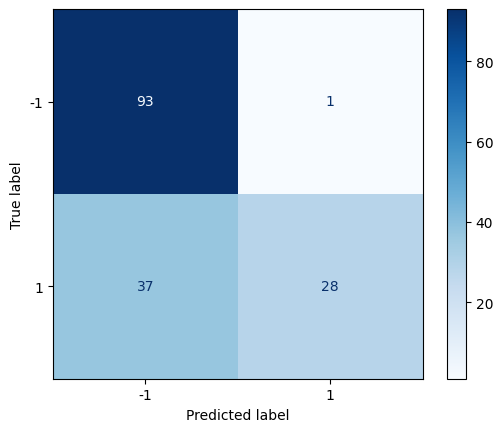

    0   1
0  93   1
1  37  28
Mean Cross-Entropy Loss (Log Loss): 3.7249
Average Accuracy: 0.1768


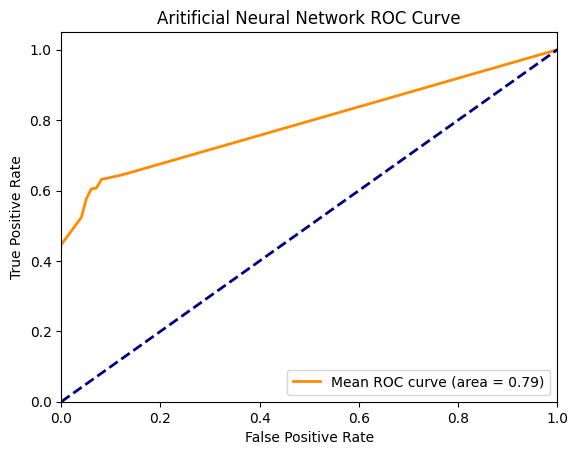

In [28]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set up K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results
cv_accuracy = []
cv_fpr = []
cv_tpr = []
cv_auc = []
log_losses = []
all_y_test = []
all_y_pred = []

for train_index, val_index in kf.split(X_scaled):
    # Split data into train and validation sets
    X_train, X_val = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Create the ANN model with one hidden layer
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Single hidden layer
    model.add(Dense(32, input_dim=64, activation='relu')) 
    model.add(Dense(1, activation='sigmoid'))  # Output layer

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Set up early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model with early stopping
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping], verbose=0)

    # Make predictions
    y_prob = model.predict(X_val) 
    y_pred = np.where(y_prob > 0.5, 1, -1)

    all_y_test.extend(y_val)
    all_y_pred.extend(y_pred)


    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_val, y_prob)
    roc_auc = auc(fpr, tpr)
    cv_accuracy.append(model.evaluate(X_val, y_val, verbose=0)[1])  # Store accuracy
    cv_fpr.append(fpr)
    cv_tpr.append(tpr)
    cv_auc.append(roc_auc)

    fold_log_loss = log_loss(y_val, y_prob)
    log_losses.append(fold_log_loss)


# Calculate classification report
print(f"Classification Report")
print(classification_report(all_y_test, all_y_pred))

# 1. Confusion Matrix
cm = confusion_matrix(all_y_test, all_y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap="Blues")
plt.show()

# Create a DataFrame with proper labels for better readability
cm_df = pd.DataFrame(cm)
print(cm_df)

mean_log_loss = np.mean(log_losses)
print(f"Mean Cross-Entropy Loss (Log Loss): {mean_log_loss:.4f}")

# Average accuracy across all folds
print(f"Average Accuracy: {np.mean(cv_accuracy):.4f}")

# Plot average ROC curve across folds
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)

for fpr, tpr in zip(cv_fpr, cv_tpr):
    mean_tpr += np.interp(mean_fpr, fpr, tpr)

mean_tpr /= len(cv_fpr)

plt.figure()
plt.plot(mean_fpr, mean_tpr, color='darkorange', lw=2, label=f'Mean ROC curve (area = {np.mean(cv_auc):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Aritificial Neural Network ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Graph of volatility against time and histogram of volatility values are plotted down below

Volatility mean : 32.067911308088505


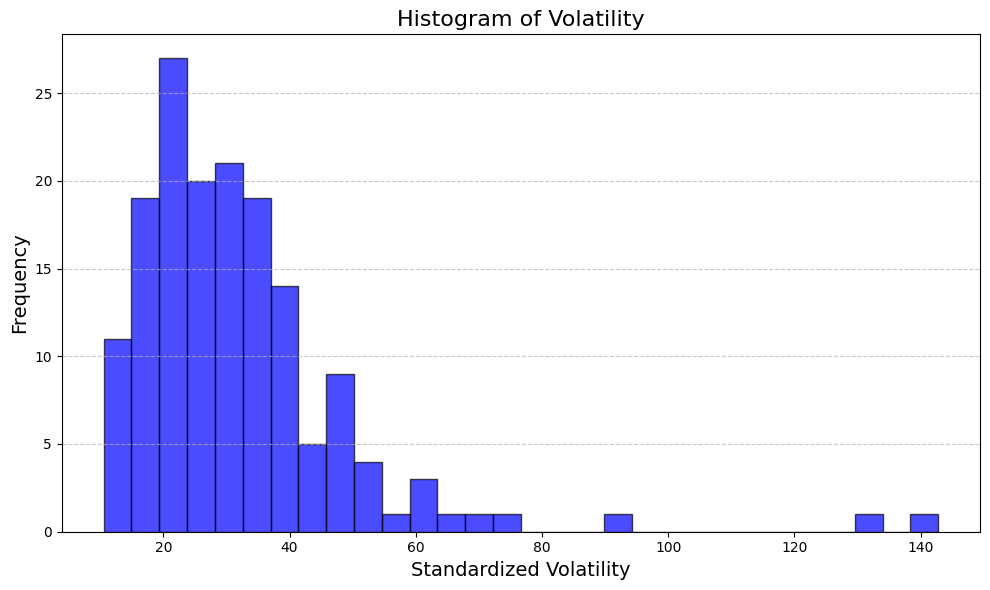

In [29]:
# Assuming your DataFrame is named `df` and the volatility column is "avg 30d volatility(t-1)"
volatility_column = "avg 30d volatility"

# Standardize the volatility column
vol_mean = df[volatility_column].mean()
vol_std = df[volatility_column].std()
print(f"Volatility mean :", vol_mean)

#df["avg 30d volatility"] = (df[volatility_column] - vol_mean) / vol_std

# Plot the histogram of standardized volatility
plt.figure(figsize=(10, 6))
plt.hist(df["avg 30d volatility"], bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Volatility', fontsize=16)
plt.xlabel('Standardized Volatility', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


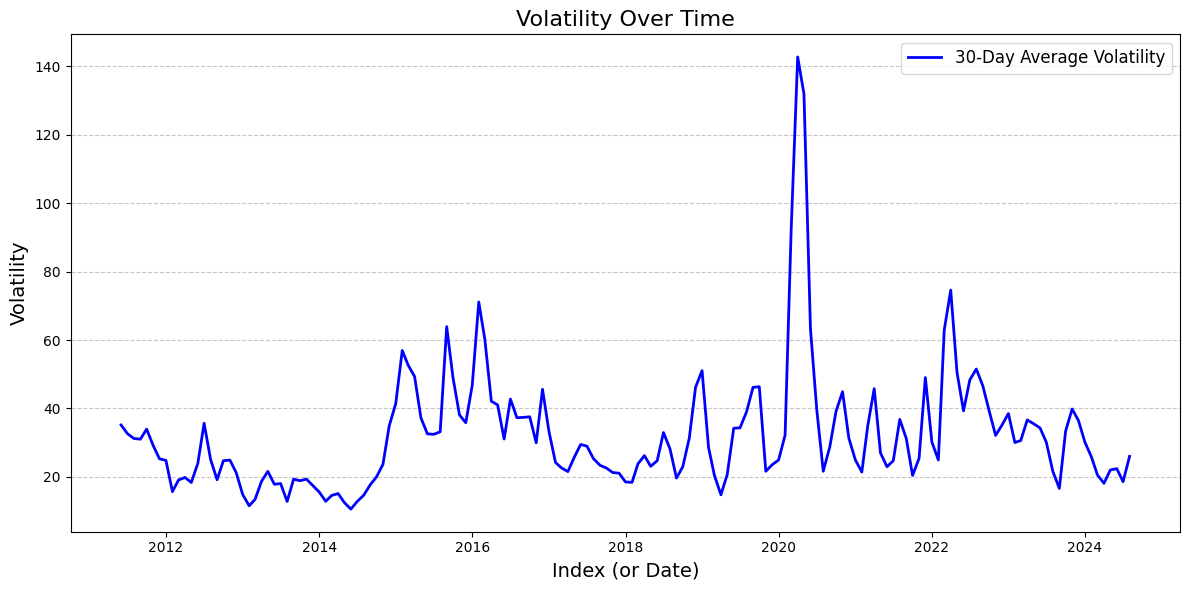

In [30]:
volatility_column = "avg 30d volatility"

# Plot the volatility
plt.figure(figsize=(12, 6))
plt.plot(df[volatility_column], label='30-Day Average Volatility', color='blue', linewidth=2)
plt.title('Volatility Over Time', fontsize=16)
plt.xlabel('Index (or Date)', fontsize=14)  # Replace with 'Date' if you have a date index
plt.ylabel('Volatility', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


**Labeling next month volatility value as target (Y)**

In [31]:
df['next month volatility'] = df['avg 30d volatility'].shift(-1)
df = df.dropna()
Y = df['next month volatility']
y = Y
X = df[X.columns]

**Fitting Random Forest Regression model and displaying performance metrics (MSE, MAE, R^2)**

Mean MSE: 106.8964
Mean MAE: 6.3011
Mean R2 Score: 0.6549


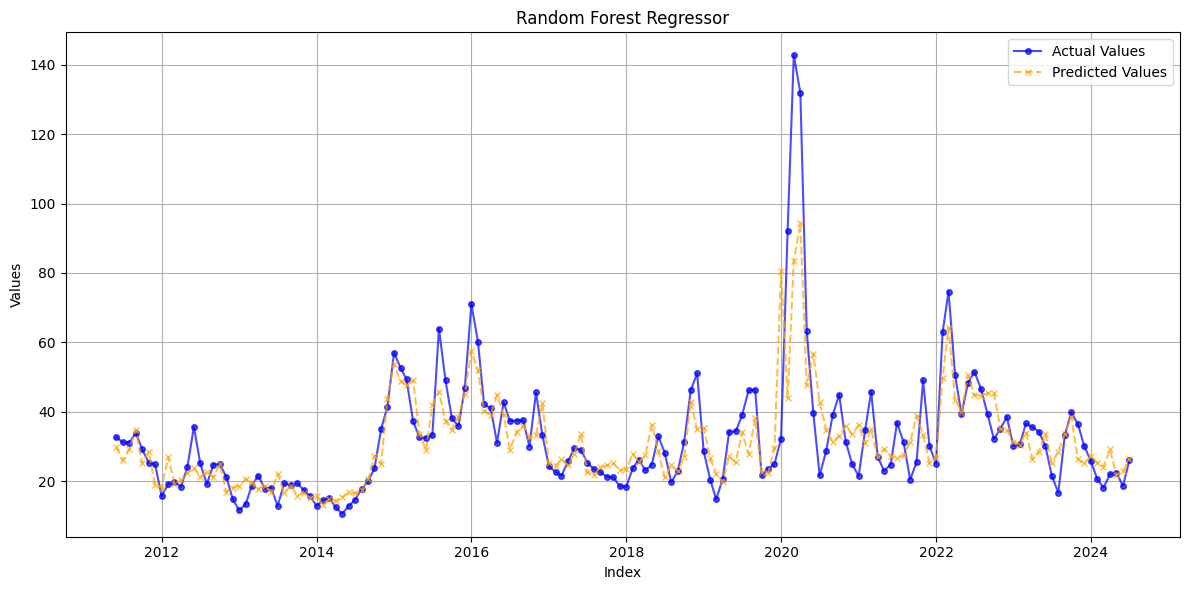

In [32]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results
all_indices = []
all_actual = []
all_predicted = []

# Metrics initialization
mse_scores = []
mae_scores = []
r2_scores = []

# Loop through each fold
for train_index, test_index in kf.split(X):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    # Initialize and fit the Random Forest Regressor
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_regressor.fit(X_train, Y_train)
    
    # Make predictions on the test set
    Y_pred = rf_regressor.predict(X_test)
    
    # Calculate performance metrics for this fold
    mse = mean_squared_error(Y_test, Y_pred)
    mae = mean_absolute_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_pred)
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    
    # Store the test indices and corresponding values
    all_indices.extend(test_index)  # Store the indices
    all_actual.extend(Y_test)      # Store actual values
    all_predicted.extend(Y_pred)   # Store predicted values

# Sort values by indices for better visualization
sorted_indices = np.argsort(all_indices)
all_indices = np.array(all_indices)[sorted_indices]
all_actual = np.array(all_actual)[sorted_indices]
all_predicted = np.array(all_predicted)[sorted_indices]

# Display average metrics
print(f"Mean MSE: {np.mean(mse_scores):.4f}")
print(f"Mean MAE: {np.mean(mae_scores):.4f}")
print(f"Mean R2 Score: {np.mean(r2_scores):.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y.index, all_actual, label='Actual Values', color='blue', marker='o', markersize=4, linestyle='-', alpha=0.7)
plt.plot(y.index, all_predicted, label='Predicted Values', color='orange', marker='x', markersize=4, linestyle='--', alpha=0.7)
plt.title('Random Forest Regressor')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Fitting Gradient Boosting Regression model and displaying performance metrics**

Mean MSE: 110.2532
Mean MAE: 6.3783
Mean R2 Score: 0.6588


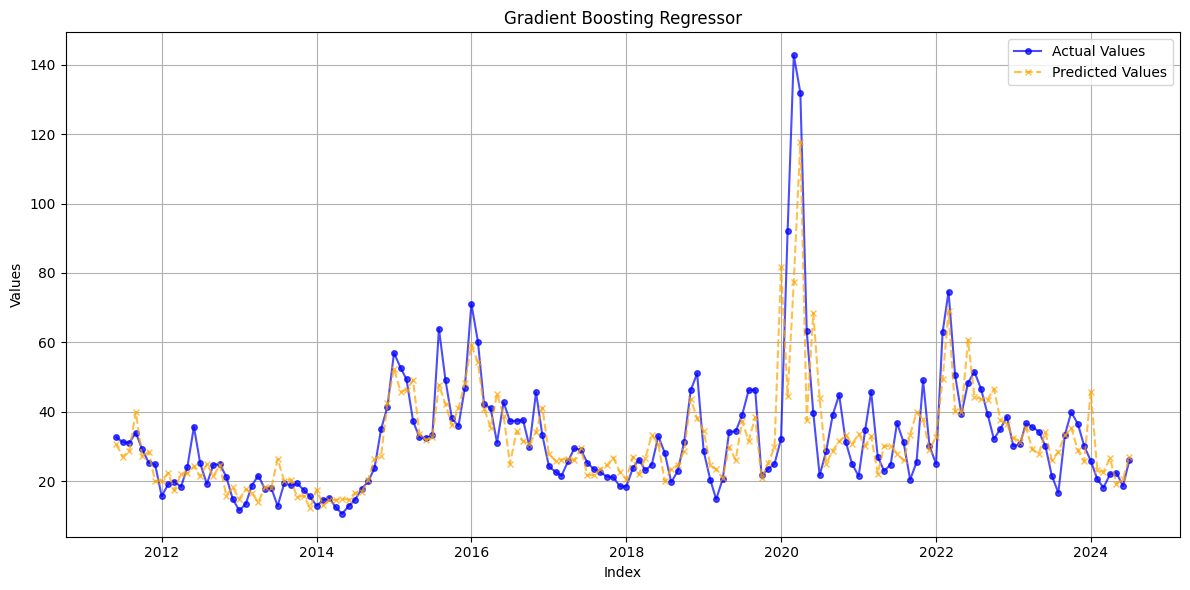

In [33]:

# Initialize K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results
all_indices = []
all_actual = []
all_predicted = []

# Metrics initialization
mse_scores = []
mae_scores = []
r2_scores = []

# Loop through each fold
for train_index, test_index in kf.split(X):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    # Initialize and fit the Gradient Boosting Regressor
    gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)
    gb_regressor.fit(X_train, Y_train)
    
    # Make predictions on the test set
    Y_pred = gb_regressor.predict(X_test)
    
    # Calculate performance metrics for this fold
    mse = mean_squared_error(Y_test, Y_pred)
    mae = mean_absolute_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_pred)
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    
    # Store the test indices and corresponding values
    all_indices.extend(test_index)  # Store the indices
    all_actual.extend(Y_test)      # Store actual values
    all_predicted.extend(Y_pred)   # Store predicted values

# Sort values by indices for better visualization
sorted_indices = np.argsort(all_indices)
all_indices = np.array(all_indices)[sorted_indices]
all_actual = np.array(all_actual)[sorted_indices]
all_predicted = np.array(all_predicted)[sorted_indices]

# Display average metrics
print(f"Mean MSE: {np.mean(mse_scores):.4f}")
print(f"Mean MAE: {np.mean(mae_scores):.4f}")
print(f"Mean R2 Score: {np.mean(r2_scores):.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y.index, all_actual, label='Actual Values', color='blue', marker='o', markersize=4, linestyle='-', alpha=0.7)
plt.plot(y.index, all_predicted, label='Predicted Values', color='orange', marker='x', markersize=4, linestyle='--', alpha=0.7)
plt.title('Gradient Boosting Regressor')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Fitting Sequential Neural Network model with 2 hidden layers and no activation function in the output layer and displaying performance metrics**

C:\Users\abdul\AppData\Local\Temp\ipykernel_4856\2959338936.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_val = Y[train_index], Y[val_index]
c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
fold R squared: [0.5989068161252866]


C:\Users\abdul\AppData\Local\Temp\ipykernel_4856\2959338936.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_val = Y[train_index], Y[val_index]
c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
fold R squared: [0.5989068161252866, 0.5173358965345494]


C:\Users\abdul\AppData\Local\Temp\ipykernel_4856\2959338936.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_val = Y[train_index], Y[val_index]
c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
fold R squared: [0.5989068161252866, 0.5173358965345494, 0.6954341701796892]


C:\Users\abdul\AppData\Local\Temp\ipykernel_4856\2959338936.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_val = Y[train_index], Y[val_index]
c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
fold R squared: [0.5989068161252866, 0.5173358965345494, 0.6954341701796892, 0.3993750522547318]


C:\Users\abdul\AppData\Local\Temp\ipykernel_4856\2959338936.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_val = Y[train_index], Y[val_index]
c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
fold R squared: [0.5989068161252866, 0.5173358965345494, 0.6954341701796892, 0.3993750522547318, 0.5916941710008208]

Average MSE: 119.2770

Average MAE: 7.9390
Average R2: 0.5605


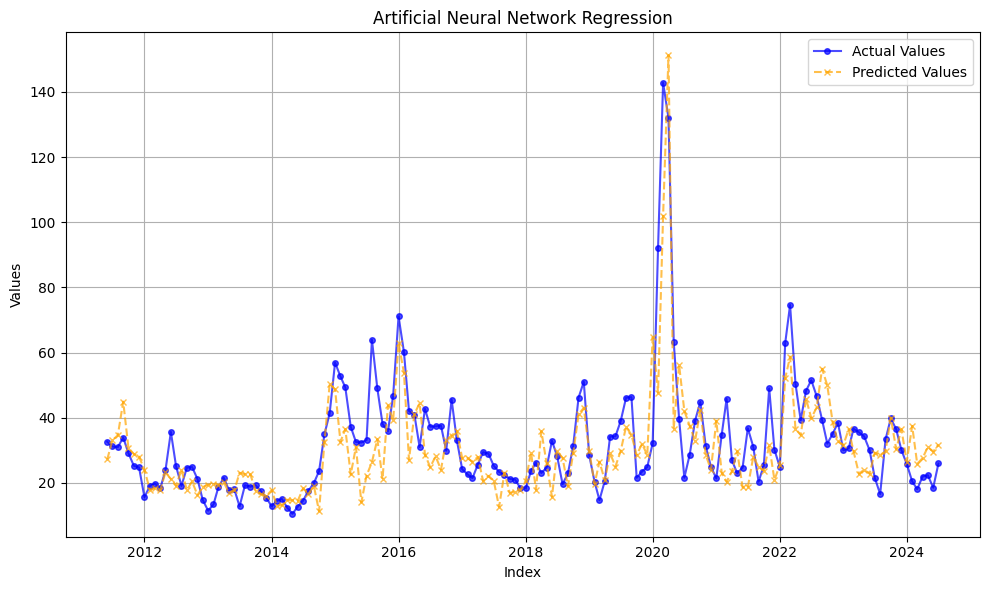

In [34]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set up K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results
cv_actual = []
cv_predictions = []
cv_r2 = []
cv_mse = []
cv_mae = []
cv_indices =[]

for train_index, val_index in kf.split(X_scaled):
    # Split data into train and validation sets
    X_train, X_val = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val = Y[train_index], Y[val_index]

    # Create the ANN model with one hidden layer
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Single hidden layer
    model.add(Dense(32, input_dim=64, activation='relu'))
    model.add(Dense(1, activation=None))  # Output layer

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

    # Set up early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model with early stopping
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping], verbose=0)

    # Make predictions
    y_pred = model.predict(X_val)

    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    cv_indices.extend(val_index)

    cv_mse.append(mse)
    cv_r2.append(r2)
    cv_mae.append(mae)
    print("fold R squared:", cv_r2)
    cv_predictions.extend(y_pred)  # Store all predictions
    cv_actual.extend(y_val) 

sorted_indices = np.argsort(cv_indices)
cv_indices = np.array(cv_indices)[sorted_indices]
cv_actual = np.array(cv_actual)[sorted_indices]
cv_predictions = np.array(cv_predictions)[sorted_indices]
# Average MSE and R2 across all folds
print(f"\nAverage MSE: {np.mean(cv_mse):.4f}")
print(f"\nAverage MAE: {np.mean(cv_mae):.4f}")
print(f"Average R2: {np.mean(cv_r2):.4f}")


# Plot indices vs actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(y.index, cv_actual, label='Actual Values', color='blue', marker='o', markersize=4, linestyle='-', alpha=0.7)
plt.plot(y.index, cv_predictions, label='Predicted Values', color='orange', marker='x', markersize=4, linestyle='--', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Artificial Neural Network Regression')
plt.legend() 
plt.grid(True)
plt.tight_layout()
plt.show()

**Tuning alpha hyperparameter in range from 10^-4 to 10^1 for Elastic Net model with fixed l1 ratio**

C:\Users\abdul\AppData\Local\Temp\ipykernel_4856\621413870.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_val = Y[train_index], Y[val_index]
C:\Users\abdul\AppData\Local\Temp\ipykernel_4856\621413870.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_val = Y[train_index], Y[val_index]
C:\Users\abdul\AppData\Local\Temp\ipykernel_4856\621413870.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train,

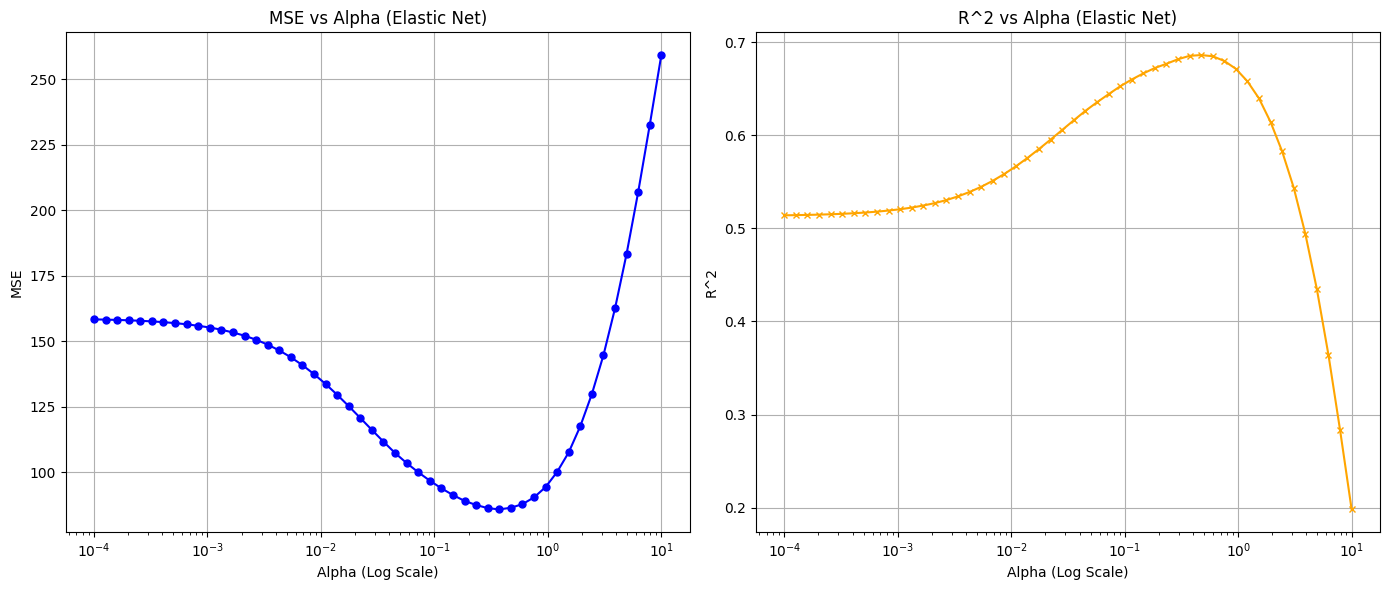

Best Alpha (based on MSE): 0.3728
Best R2 at this alpha: 0.6862


In [35]:
# Define a range of alpha values to search over
alphas = np.logspace(-4, 1, 50)  # Range from 10^-4 to 10^1

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set up K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results
cv_mse = []
cv_r2 = []
alpha_results = []

# Loop through each alpha value
for alpha in alphas:
    fold_mse = []
    fold_r2 = []

    # Loop through each fold
    for train_index, val_index in kf.split(X_scaled):
        # Split data into train and validation sets
        X_train, X_val = X_scaled[train_index], X_scaled[val_index]
        y_train, y_val = Y[train_index], Y[val_index]

        # Create the Elastic Net model with the current alpha
        elastic_net = ElasticNet(alpha=alpha, l1_ratio=0.5)
        elastic_net.fit(X_train, y_train)

        # Make predictions
        y_pred = elastic_net.predict(X_val)

        # Calculate performance metrics for this fold
        mse = mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)

        fold_mse.append(mse)
        fold_r2.append(r2)

    # Store the average results for this alpha
    cv_mse.append(np.mean(fold_mse))
    cv_r2.append(np.mean(fold_r2))
    alpha_results.append(alpha)

# Find the best alpha based on lowest MSE
best_alpha_mse = alpha_results[np.argmin(cv_mse)]
best_r2_mse = np.max(cv_r2)  # Best R2 for the best MSE

# Create a figure with two subplots (one for MSE and one for R^2)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot MSE on the first subplot
ax[0].plot(alpha_results, cv_mse, label='MSE', color='blue', marker='o', markersize=5)
ax[0].set_xscale('log')
ax[0].set_xlabel('Alpha (Log Scale)')
ax[0].set_ylabel('MSE')
ax[0].set_title('MSE vs Alpha (Elastic Net)')
ax[0].grid(True)

# Plot R^2 on the second subplot
ax[1].plot(alpha_results, cv_r2, label='R^2', color='orange', marker='x', markersize=5)
ax[1].set_xscale('log')
ax[1].set_xlabel('Alpha (Log Scale)')
ax[1].set_ylabel('R^2')
ax[1].set_title('R^2 vs Alpha (Elastic Net)')
ax[1].grid(True)

# Adjust layout for better display
plt.tight_layout()

# Show the plots
plt.show()


# Output the best alpha value
print(f"Best Alpha (based on MSE): {best_alpha_mse:.4f}")
print(f"Best R2 at this alpha: {best_r2_mse:.4f}")


**Fitting Elastic Net model using the best alpha obtained and storing the coefficients of features for display**

Mean MSE: 86.3683
Mean MAE: 6.3558
Mean R2 Score: 0.6817

Average Coefficients:
"WTI_w": 4.4725
DXY: 0.6122
"oil price_w": 4.4766
"COPR_NONOPEC": 1.2475
"OPEC_w": 1.8718
VIX: 5.9043
monthly_finbert_score_mean: 0.2148
"war_w": 0.5483
"oil_sa": 0.9558
"saudi_w": 0.9595
"COPR_WORLD": 2.4948
"PASC_OECD_T3": 0.9905


C:\Users\abdul\AppData\Local\Temp\ipykernel_4856\749224376.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_val = Y[train_index], Y[val_index]
C:\Users\abdul\AppData\Local\Temp\ipykernel_4856\749224376.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_val = Y[train_index], Y[val_index]
C:\Users\abdul\AppData\Local\Temp\ipykernel_4856\749224376.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train,

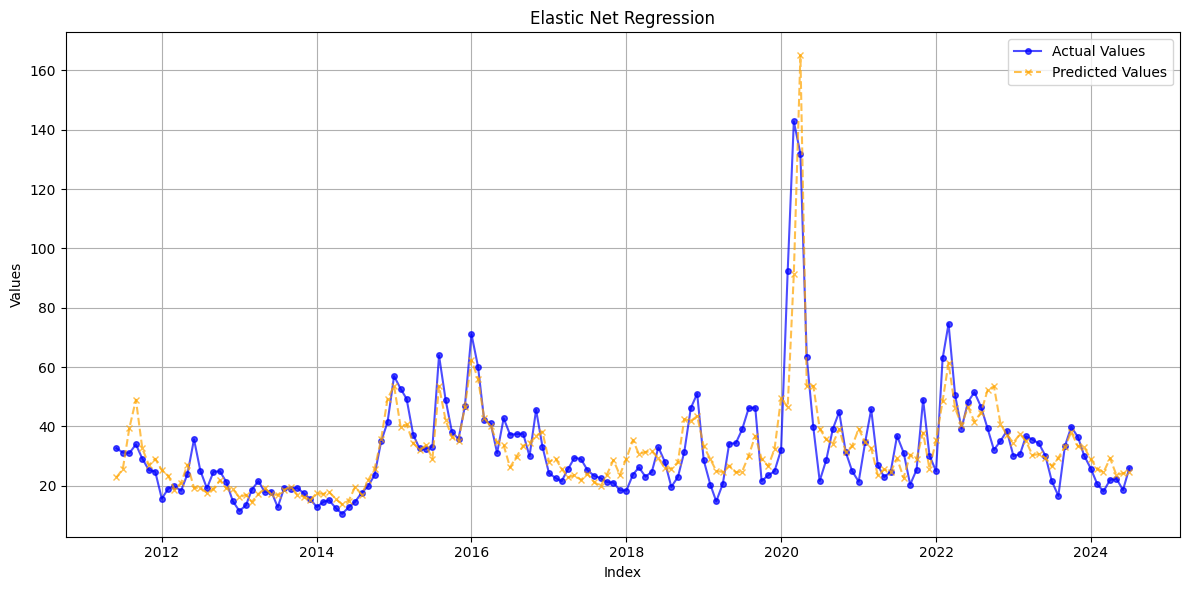

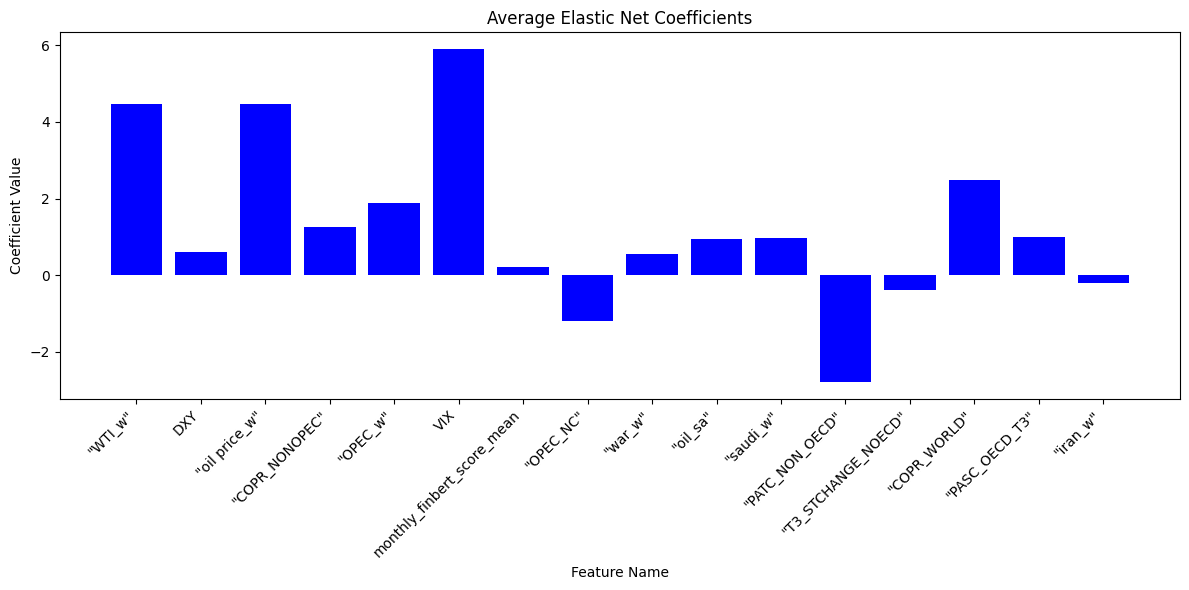

In [36]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set up K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results
cv_actual = []
cv_predictions = []
cv_r2 = []
cv_mse = []
cv_mae = []
cv_indices = []

# Initialize a list to store the coefficients
all_coefficients = []

# Loop through each fold
for train_index, val_index in kf.split(X_scaled):
    # Split data into train and validation sets
    X_train, X_val = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val = Y[train_index], Y[val_index]

    # Create the Elastic Net model
    elastic_net = ElasticNet(alpha=0.2947, l1_ratio=0.5)  # alpha is the regularization strength, l1_ratio controls the mix of L1 and L2
    elastic_net.fit(X_train, y_train)

    # Store the coefficients for this fold
    all_coefficients.append(elastic_net.coef_)

    # Make predictions
    y_pred = elastic_net.predict(X_val)

    # Calculate performance metrics for this fold
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)

    # Append the metrics
    cv_mse.append(mse)
    cv_r2.append(r2)
    cv_mae.append(mae)
    
    cv_predictions.extend(y_pred)
    cv_actual.extend(y_val)
    cv_indices.extend(val_index)

# Sort values by indices for better visualization
sorted_indices = np.argsort(cv_indices)
cv_indices = np.array(cv_indices)[sorted_indices]
cv_actual = np.array(cv_actual)[sorted_indices]
cv_predictions = np.array(cv_predictions)[sorted_indices]

# Display average metrics
print(f"Mean MSE: {np.mean(cv_mse):.4f}")
print(f"Mean MAE: {np.mean(cv_mae):.4f}")
print(f"Mean R2 Score: {np.mean(cv_r2):.4f}")

# Average coefficients across all folds
average_coefficients = np.mean(all_coefficients, axis=0)

print("\nAverage Coefficients:")
for feature_name, coef in zip(X.columns, average_coefficients):
    if coef > 0:
        print(f"{feature_name}: {coef:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y.index, cv_actual, label='Actual Values', color='blue', marker='o', markersize=4, linestyle='-', alpha=0.7)
plt.plot(y.index, cv_predictions, label='Predicted Values', color='orange', marker='x', markersize=4, linestyle='--', alpha=0.7)
plt.title('Elastic Net Regression')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Assuming 'feature_names' is a list of names corresponding to the features
feature_names = X.columns  # If using a DataFrame for X, get the column names

# Plot the average coefficients with feature names
plt.figure(figsize=(12, 6))
plt.bar(feature_names, average_coefficients, color='blue')
plt.title('Average Elastic Net Coefficients')
plt.xlabel('Feature Name')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()
